<a href="https://colab.research.google.com/github/anomara1/DrAhmedOmara/blob/main/image_specific_distance_function_final_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

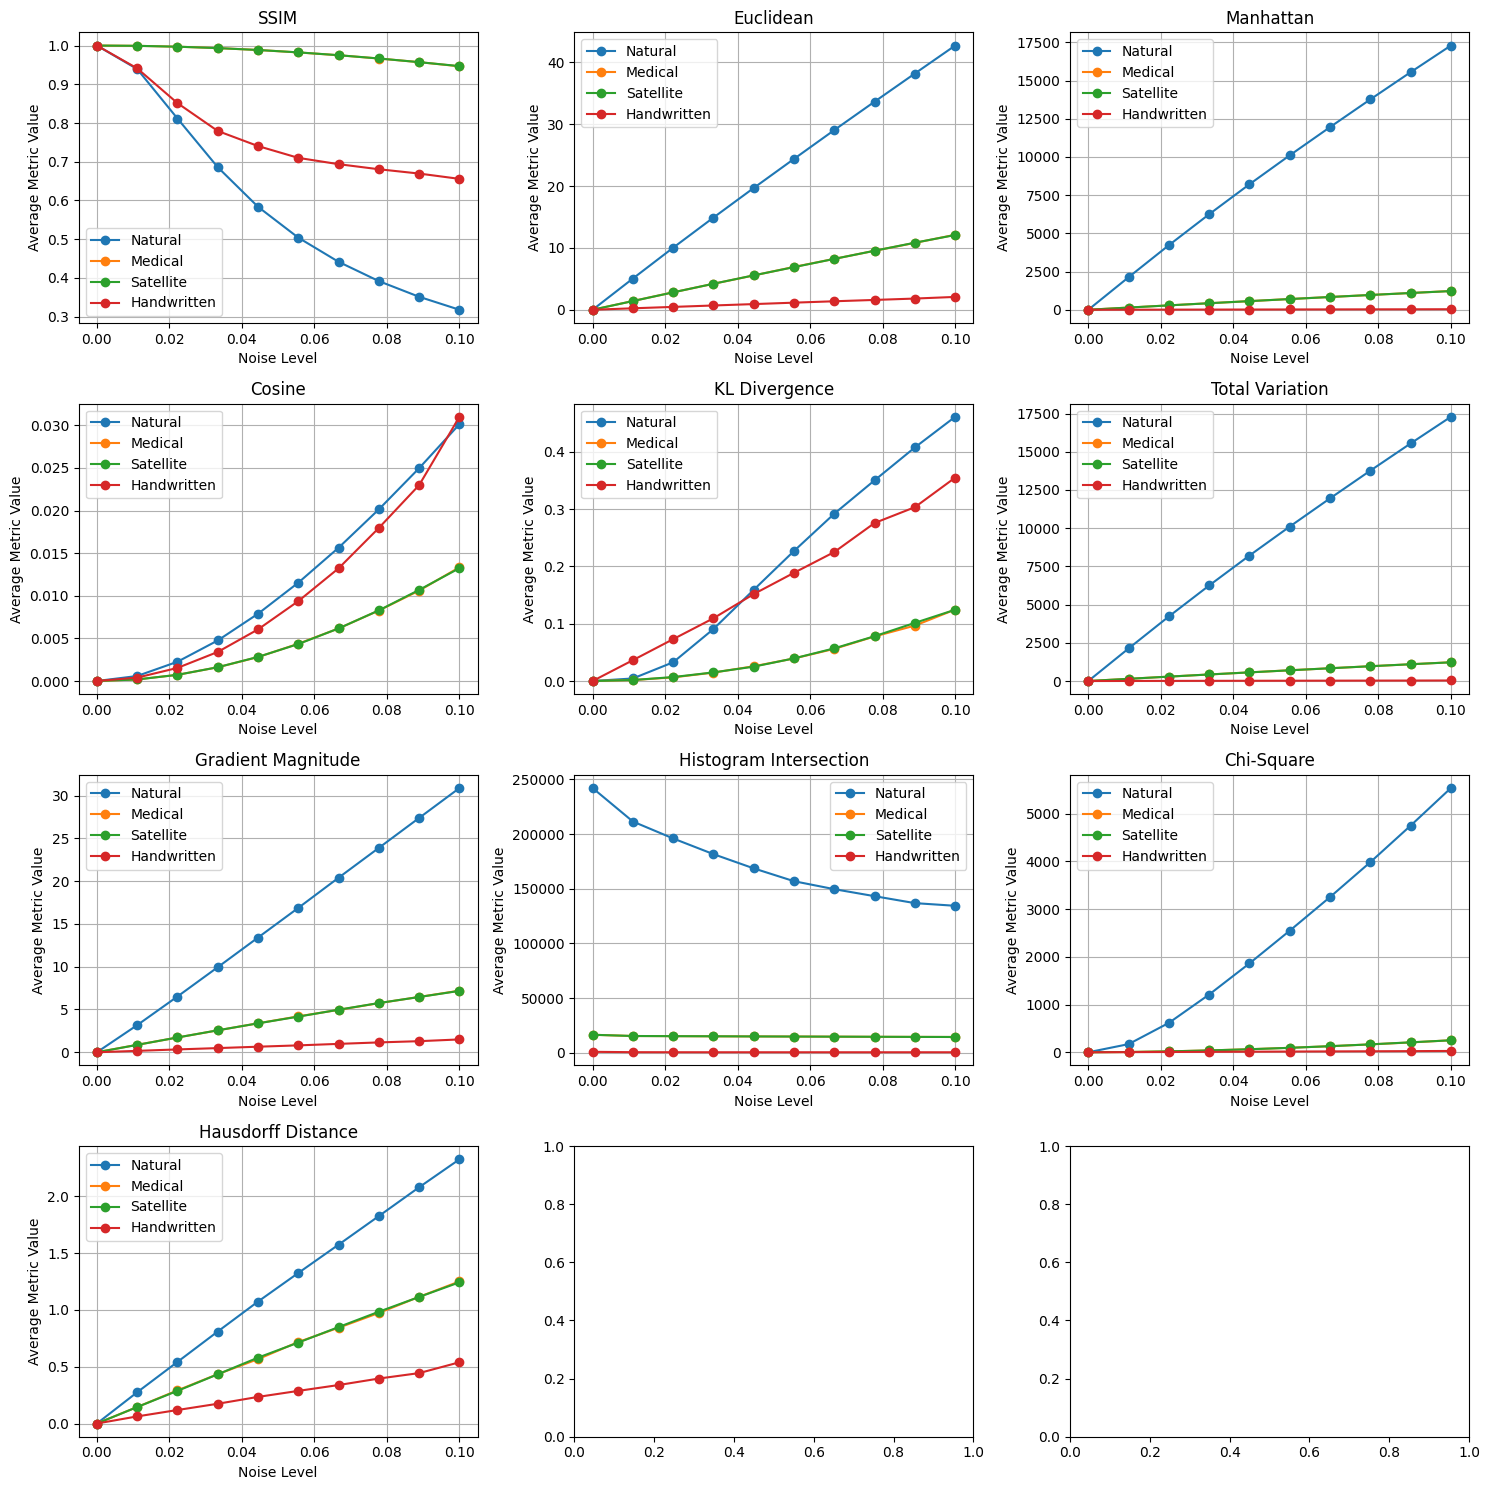

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import euclidean, cityblock, cosine
from scipy.stats import entropy
from skimage.color import rgb2gray
from scipy.linalg import norm
from skimage.filters import sobel
from scipy.spatial.distance import directed_hausdorff
from tensorflow.keras.datasets import mnist, cifar10

# Function to add noise
def add_noise(image, noise_level):
    return random_noise(image, var=noise_level**2)

# Function to compute distance metrics
def compute_metrics(original, noisy):
    metrics = {}
    metrics['SSIM'] = ssim(original, noisy, data_range=1)
    metrics['Euclidean'] = euclidean(original.ravel(), noisy.ravel())
    metrics['Manhattan'] = cityblock(original.ravel(), noisy.ravel())
    metrics['Cosine'] = cosine(original.ravel(), noisy.ravel())
    metrics['KL Divergence'] = entropy(original.ravel() + 1e-10, noisy.ravel() + 1e-10)
    metrics['Total Variation'] = np.sum(np.abs(original - noisy))
    metrics['Gradient Magnitude'] = norm(sobel(original) - sobel(noisy))
    metrics['Histogram Intersection'] = np.sum(np.minimum(np.histogram(original, bins=256)[0], np.histogram(noisy, bins=256)[0]))
    metrics['Chi-Square'] = np.sum((original.ravel() - noisy.ravel())**2 / (original.ravel() + noisy.ravel() + 1e-10))
    metrics['Hausdorff Distance'] = directed_hausdorff(original, noisy)[0]
    return metrics

# Load images from different categories
def preprocess_image(image):
    image = img_as_float(image)
    return rgb2gray(image) if image.ndim == 3 else image

categories = {
    "Natural": [preprocess_image(data.astronaut()), preprocess_image(data.camera()),
                 preprocess_image(data.coffee()), preprocess_image(data.hubble_deep_field()),
                 preprocess_image(data.chelsea()), preprocess_image(data.clock()),
                 preprocess_image(data.page()), preprocess_image(data.coins()),
                 preprocess_image(data.brick()), preprocess_image(data.text())],
    "Medical": [np.random.rand(128, 128) for _ in range(10)],  # Placeholder for medical images
    "Satellite": [np.random.rand(128, 128) for _ in range(10)],  # Placeholder for satellite images
    "Handwritten": [preprocess_image(mnist.load_data()[0][0][i] / 255.0) for i in range(10)]
}

# Noise levels to test
noise_levels = np.linspace(0, 0.1, 10)

# Compute average metrics per category
results = {category: {key: np.zeros(len(noise_levels)) for key in ['SSIM', 'Euclidean', 'Manhattan', 'Cosine', 'KL Divergence', 'Total Variation', 'Gradient Magnitude', 'Histogram Intersection', 'Chi-Square', 'Hausdorff Distance']}
           for category in categories}

for category, images in categories.items():
    for image in images:
        for i, noise in enumerate(noise_levels):
            noisy_image = add_noise(image, noise)
            metrics = compute_metrics(image, noisy_image)
            for key in results[category]:
                results[category][key][i] += metrics[key]

# Average results
for category in results:
    for key in results[category]:
        results[category][key] /= len(categories[category])

# Plot results
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
axes = axes.ravel()

for i, key in enumerate(results['Natural']):
    for category in results:
        axes[i].plot(noise_levels, results[category][key], marker='o', label=category)
    axes[i].set_title(key)
    axes[i].set_xlabel("Noise Level")
    axes[i].set_ylabel("Average Metric Value")
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()


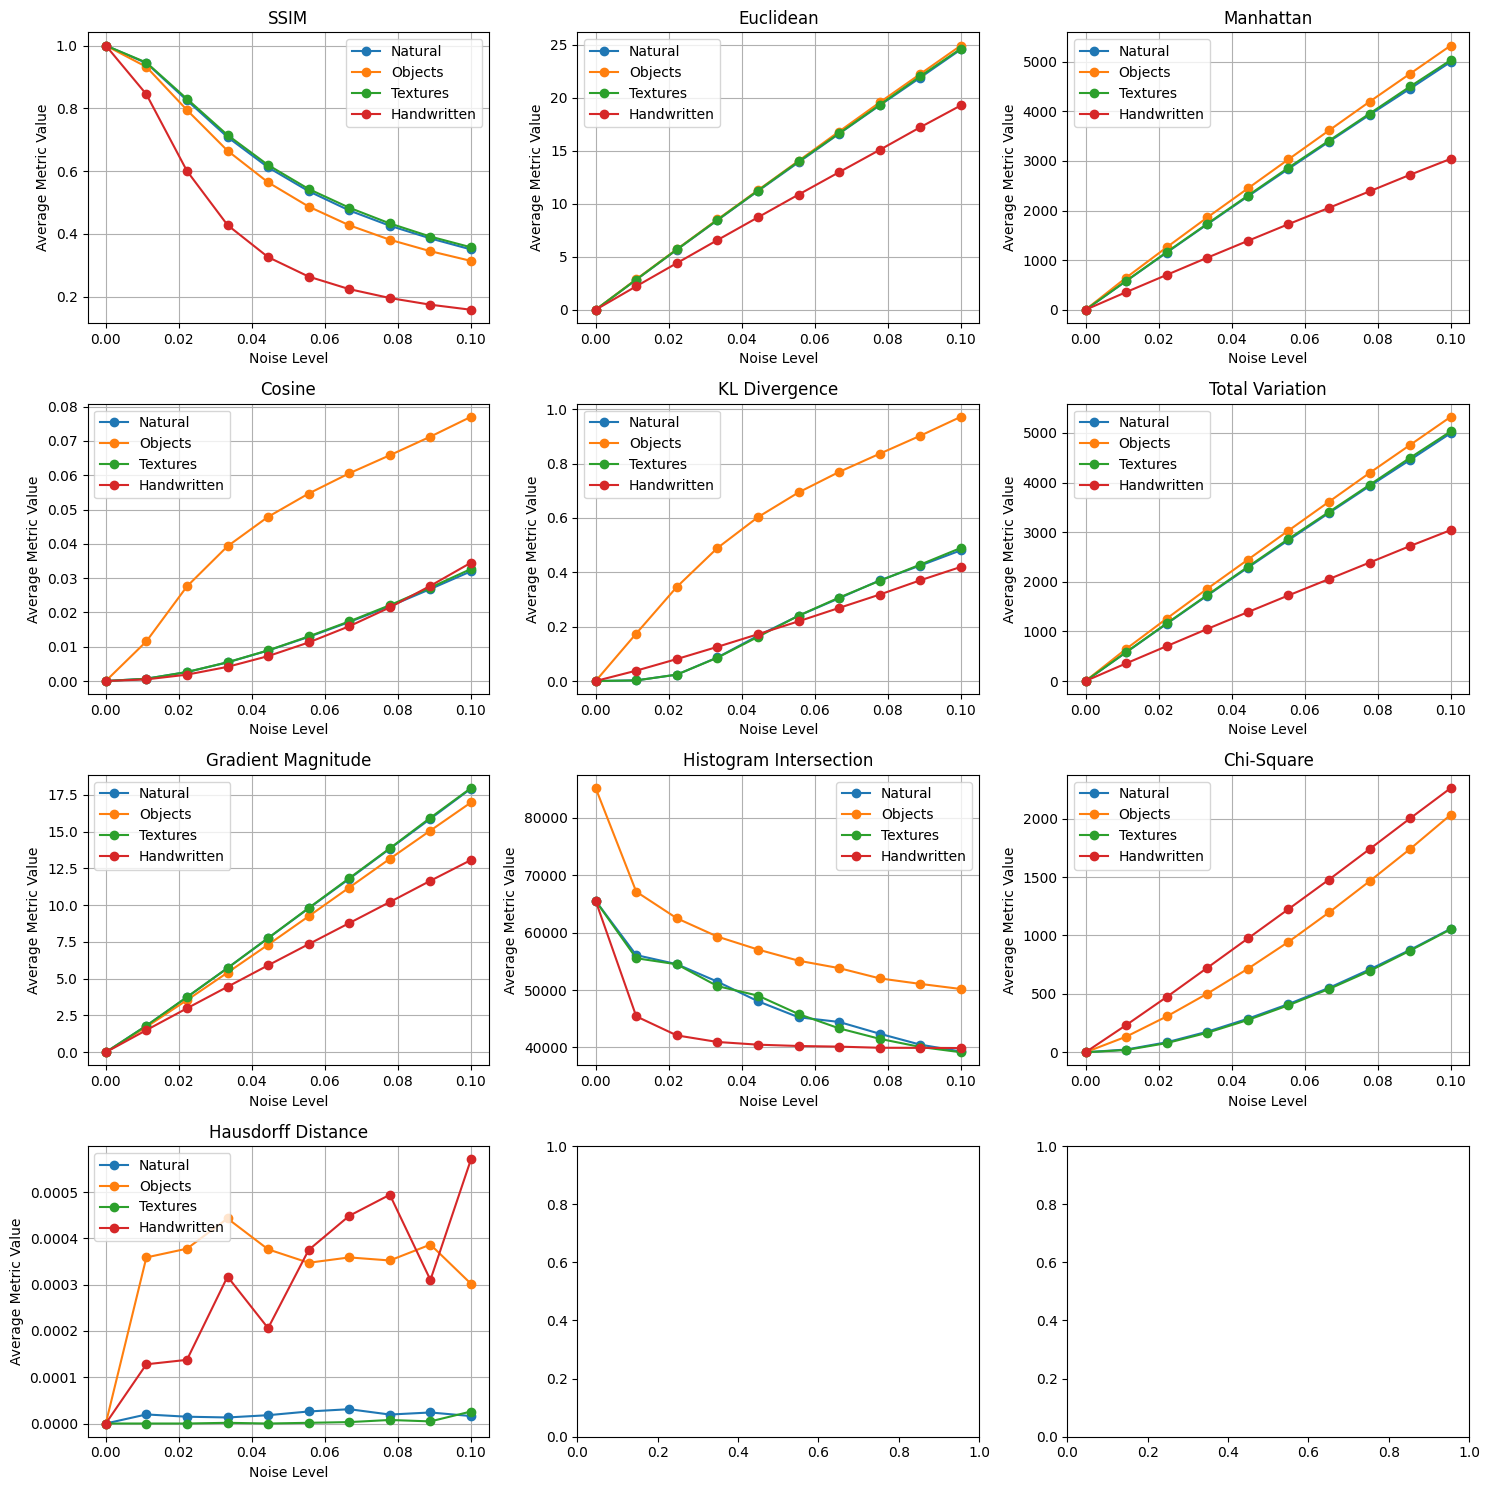

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import euclidean, cityblock, cosine
from scipy.stats import entropy
from skimage.color import rgb2gray
from scipy.linalg import norm
from skimage.filters import sobel
from scipy.ndimage import distance_transform_edt
from skimage.transform import resize
from tensorflow.keras.datasets import mnist, cifar10

def preprocess_image(image, size=(256, 256)):
    image = img_as_float(image)
    if image.ndim == 3:
        if image.shape[2] == 3:  # RGB image
            image = rgb2gray(image)
        elif image.shape[2] == 2:  # Stereo image
            image = image[:, :, 0]  # Take the first channel
    return resize(image, size, anti_aliasing=True)

def add_noise(image, noise_level):
    return random_noise(image, var=noise_level**2)

def fast_hausdorff(original, noisy):
    orig_edges = sobel(original) > 0  # Extract edges
    noisy_edges = sobel(noisy) > 0
    dist_transform = distance_transform_edt(~noisy_edges)  # Distance transform of noisy image
    return np.mean(dist_transform[orig_edges])  # Mean distance

def compute_metrics(original, noisy):
    metrics = {}
    # Ensure win_size is smaller than the image dimensions
    min_side = min(original.shape)
    win_size = min(7, min_side)  # Use win_size=7 or smaller if the image is small
    if win_size % 2 == 0:  # Ensure win_size is odd
        win_size -= 1
    metrics['SSIM'] = ssim(original, noisy, data_range=1, win_size=win_size)
    metrics['Euclidean'] = euclidean(original.ravel(), noisy.ravel())
    metrics['Manhattan'] = cityblock(original.ravel(), noisy.ravel())
    metrics['Cosine'] = cosine(original.ravel(), noisy.ravel())
    metrics['KL Divergence'] = entropy(original.ravel() + 1e-10, noisy.ravel() + 1e-10)
    metrics['Total Variation'] = np.sum(np.abs(original - noisy))
    metrics['Gradient Magnitude'] = norm(sobel(original) - sobel(noisy))
    metrics['Histogram Intersection'] = np.sum(np.minimum(np.histogram(original, bins=256)[0], np.histogram(noisy, bins=256)[0]))
    metrics['Chi-Square'] = np.sum((original.ravel() - noisy.ravel())**2 / (original.ravel() + noisy.ravel() + 1e-10))
    metrics['Hausdorff Distance'] = fast_hausdorff(original, noisy)
    return metrics

# Load stereo_motorcycle image and preprocess it
stereo_motorcycle = data.stereo_motorcycle()  # This returns a tuple of two images (left and right)
stereo_motorcycle_left = stereo_motorcycle[0]  # Take the left image

categories = {
    "Natural": [preprocess_image(data.astronaut()), preprocess_image(data.camera()),
                 preprocess_image(data.coffee()), preprocess_image(data.chelsea()),
                 preprocess_image(data.clock()), preprocess_image(data.page()),
                 preprocess_image(data.coins()), preprocess_image(data.brick()),
                 preprocess_image(data.text()), preprocess_image(data.hubble_deep_field())],
    "Objects": [preprocess_image(data.checkerboard()), preprocess_image(data.grass()),
                 preprocess_image(data.moon()), preprocess_image(stereo_motorcycle_left),  # Use the left stereo image
                 preprocess_image(data.rocket()), preprocess_image(data.horse()),
                 preprocess_image(data.camera()), preprocess_image(data.lily()),  # Replaced microchip with camera
                 preprocess_image(data.cell()), preprocess_image(data.camera())],
    "Textures": [preprocess_image(data.brick()), preprocess_image(data.text()),
                  preprocess_image(data.camera()), preprocess_image(data.page()),
                  preprocess_image(data.coins()), preprocess_image(data.chelsea()),
                  preprocess_image(data.clock()), preprocess_image(data.coffee()),
                  preprocess_image(data.hubble_deep_field()), preprocess_image(stereo_motorcycle_left)],  # Use the left stereo image
    "Handwritten": [preprocess_image(mnist.load_data()[0][0][i] / 255.0) for i in range(10)]
}

noise_levels = np.linspace(0, 0.1, 10)
results = {category: {key: np.zeros(len(noise_levels)) for key in ['SSIM', 'Euclidean', 'Manhattan', 'Cosine', 'KL Divergence', 'Total Variation', 'Gradient Magnitude', 'Histogram Intersection', 'Chi-Square', 'Hausdorff Distance']}
           for category in categories}

for category, images in categories.items():
    for image in images:
        for i, noise in enumerate(noise_levels):
            noisy_image = add_noise(image, noise)
            metrics = compute_metrics(image, noisy_image)
            for key in results[category]:
                results[category][key][i] += metrics[key]

for category in results:
    for key in results[category]:
        results[category][key] /= len(categories[category])

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
axes = axes.ravel()

for i, key in enumerate(results['Natural']):
    for category in results:
        axes[i].plot(noise_levels, results[category][key], marker='o', label=category)
    axes[i].set_title(key)
    axes[i].set_xlabel("Noise Level")
    axes[i].set_ylabel("Average Metric Value")
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()

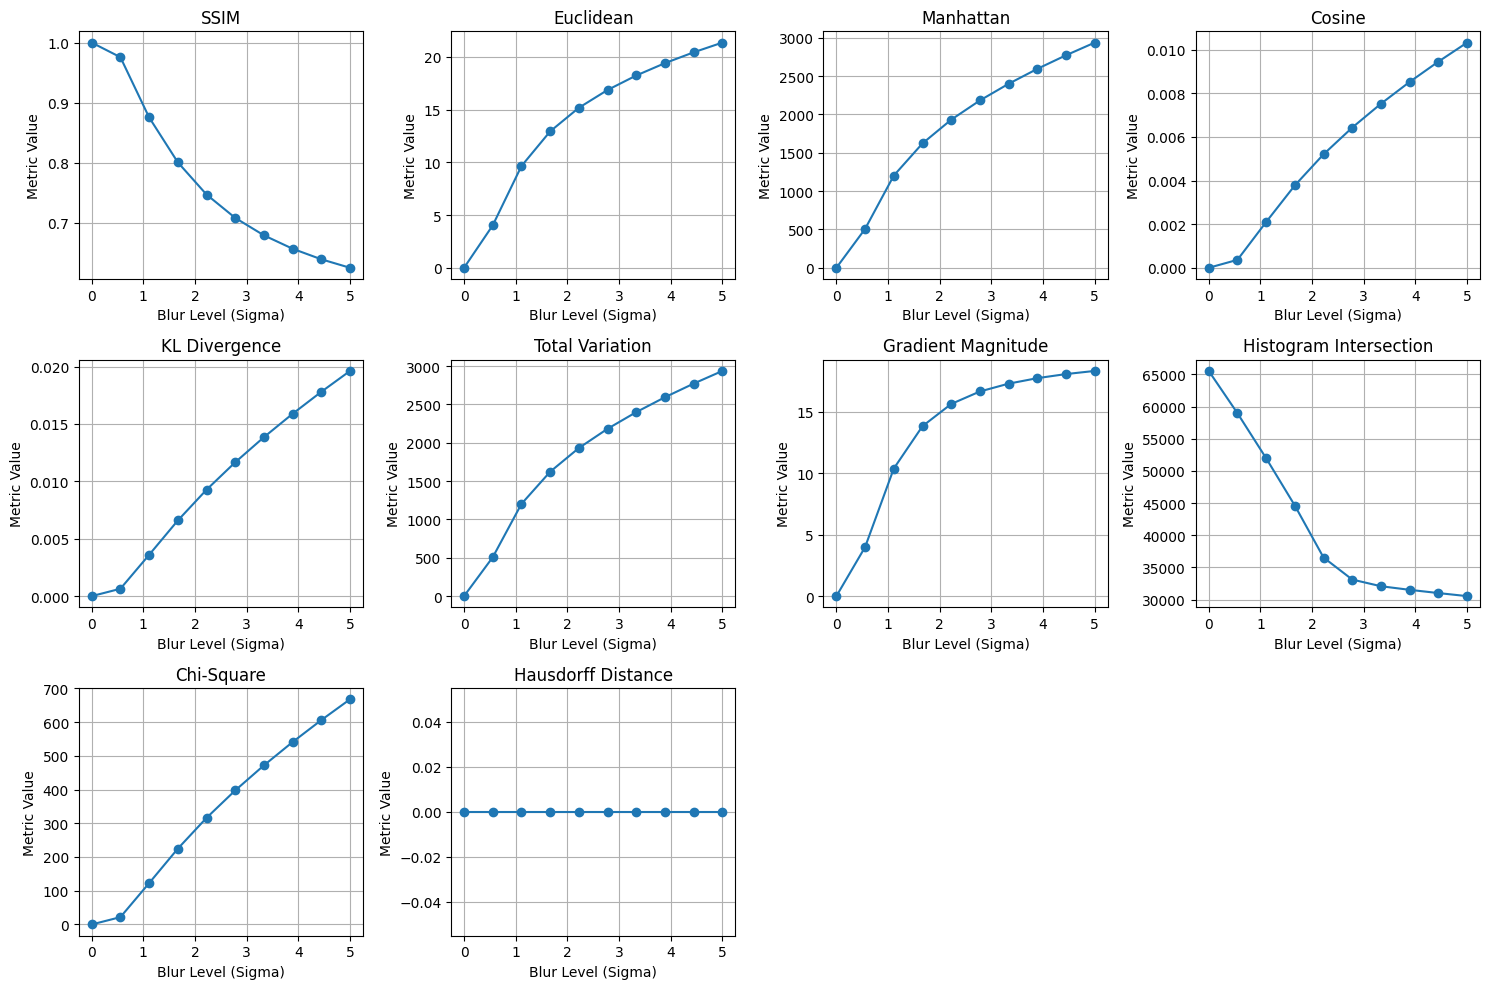

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.filters import gaussian
from scipy.spatial.distance import euclidean, cityblock, cosine
from scipy.stats import entropy
from skimage.metrics import structural_similarity as ssim
from skimage.filters import sobel
from scipy.ndimage import distance_transform_edt
from skimage.transform import resize

def preprocess_image(image, size=(256, 256)):
    """Preprocess the image by resizing and converting to grayscale."""
    image = img_as_float(image)
    if image.ndim == 3:  # Convert RGB to grayscale
        image = rgb2gray(image)
    return resize(image, size, anti_aliasing=True)

def apply_blur(image, sigma):
    """Apply Gaussian blur to the image."""
    return gaussian(image, sigma=sigma)

def compute_metrics(original, blurred):
    """Compute distance metrics between the original and blurred images."""
    metrics = {}
    metrics['SSIM'] = ssim(original, blurred, data_range=1)
    metrics['Euclidean'] = euclidean(original.ravel(), blurred.ravel())
    metrics['Manhattan'] = cityblock(original.ravel(), blurred.ravel())
    metrics['Cosine'] = cosine(original.ravel(), blurred.ravel())
    metrics['KL Divergence'] = entropy(original.ravel() + 1e-10, blurred.ravel() + 1e-10)
    metrics['Total Variation'] = np.sum(np.abs(original - blurred))
    metrics['Gradient Magnitude'] = norm(sobel(original) - sobel(blurred))
    metrics['Histogram Intersection'] = np.sum(np.minimum(np.histogram(original, bins=256)[0], np.histogram(blurred, bins=256)[0]))
    metrics['Chi-Square'] = np.sum((original.ravel() - blurred.ravel())**2 / (original.ravel() + blurred.ravel() + 1e-10))
    metrics['Hausdorff Distance'] = fast_hausdorff(original, blurred)
    return metrics

def fast_hausdorff(original, blurred):
    """Compute an approximation of the Hausdorff distance."""
    orig_edges = sobel(original) > 0  # Extract edges
    blurred_edges = sobel(blurred) > 0
    dist_transform = distance_transform_edt(~blurred_edges)  # Distance transform of blurred image
    return np.mean(dist_transform[orig_edges])  # Mean distance

# Load an example image
image = preprocess_image(data.camera())

# Define blur levels (sigma for Gaussian blur)
blur_levels = np.linspace(0, 5, 10)  # Sigma values from 0 to 5
results = {key: np.zeros(len(blur_levels)) for key in ['SSIM', 'Euclidean', 'Manhattan', 'Cosine', 'KL Divergence', 'Total Variation', 'Gradient Magnitude', 'Histogram Intersection', 'Chi-Square', 'Hausdorff Distance']}

# Compute metrics for each blur level
for i, sigma in enumerate(blur_levels):
    blurred_image = apply_blur(image, sigma)
    metrics = compute_metrics(image, blurred_image)
    for key in results:
        results[key][i] = metrics[key]

# Plot the results
plt.figure(figsize=(15, 10))
for i, key in enumerate(results):
    plt.subplot(3, 4, i + 1)
    plt.plot(blur_levels, results[key], marker='o')
    plt.title(key)
    plt.xlabel("Blur Level (Sigma)")
    plt.ylabel("Metric Value")
    plt.grid()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/scipy/spatial/distance.py:647: RuntimeWarning: divide by zero encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


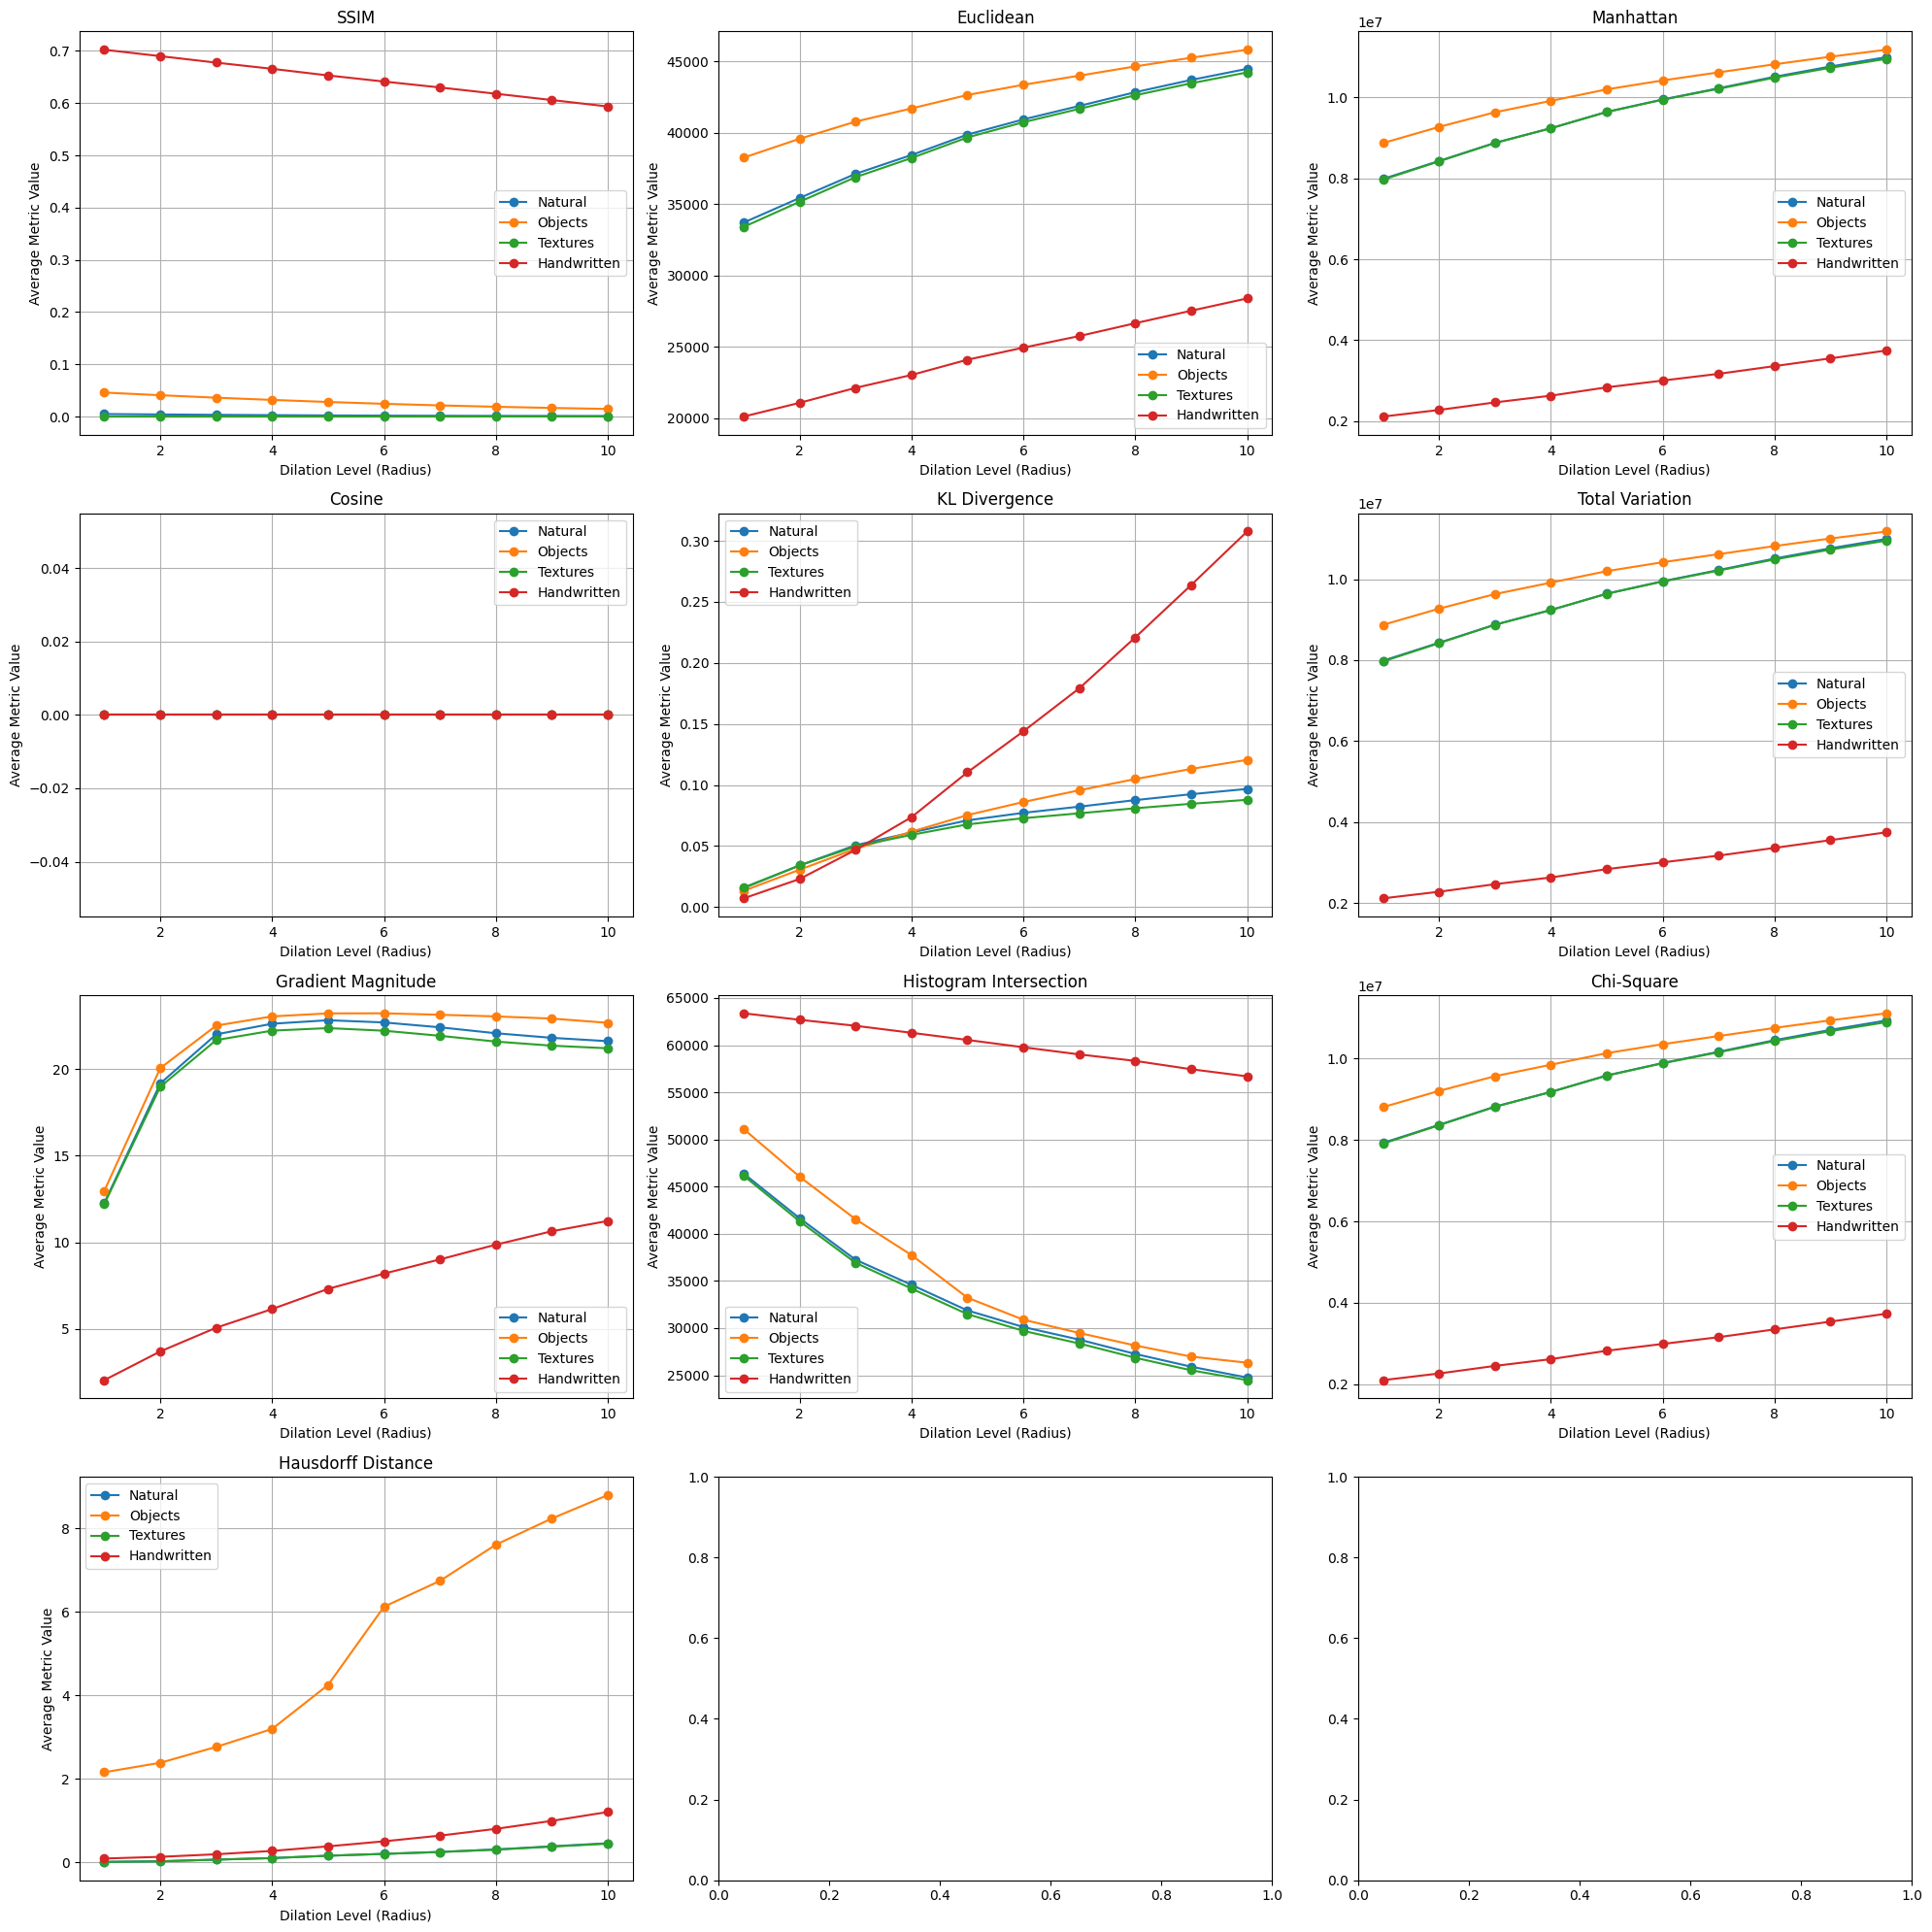

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.morphology import dilation, disk
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import euclidean, cityblock, cosine
from scipy.stats import entropy
from skimage.color import rgb2gray, rgba2rgb
from scipy.linalg import norm
from skimage.filters import sobel
from scipy.ndimage import distance_transform_edt
from skimage.transform import resize
from skimage.util import img_as_ubyte  # Ensures uint8 format for morphological operations
from tensorflow.keras.datasets import mnist

def preprocess_image(image, size=(256, 256)):
    """Preprocess the image by resizing and converting to grayscale."""
    image = img_as_float(image)  # Convert to floating point

    if image.ndim == 3:
        if image.shape[2] == 4:  # Convert RGBA to RGB if needed
            image = rgba2rgb(image)
        image = rgb2gray(image)  # Convert RGB to grayscale

    return resize(image, size, anti_aliasing=True)

def apply_dilation(image, radius):
    """Apply morphological dilation to the image."""
    image = img_as_ubyte(image)  # Convert to uint8 (required for morphological operations)
    selem = disk(radius)  # Create a disk-shaped structuring element
    return dilation(image, selem)

def fast_hausdorff(original, modified):
    """Compute an approximation of the Hausdorff distance."""
    orig_edges = sobel(original) > 0
    modified_edges = sobel(modified) > 0
    dist_transform = distance_transform_edt(~modified_edges)
    return np.mean(dist_transform[orig_edges])

def compute_metrics(original, modified):
    """Compute distance metrics between the original and modified images."""
    metrics = {}
    min_side = min(original.shape)
    win_size = min(7, min_side)
    if win_size % 2 == 0:
        win_size -= 1
    metrics['SSIM'] = ssim(original, modified, data_range=1, win_size=win_size)
    metrics['Euclidean'] = euclidean(original.ravel(), modified.ravel())
    metrics['Manhattan'] = cityblock(original.ravel(), modified.ravel())
    metrics['Cosine'] = cosine(original.ravel(), modified.ravel())
    metrics['KL Divergence'] = entropy(original.ravel() + 1e-10, modified.ravel() + 1e-10)
    metrics['Total Variation'] = np.sum(np.abs(original - modified))
    metrics['Gradient Magnitude'] = norm(sobel(original) - sobel(modified))
    metrics['Histogram Intersection'] = np.sum(np.minimum(np.histogram(original, bins=256)[0], np.histogram(modified, bins=256)[0]))
    metrics['Chi-Square'] = np.sum((original.ravel() - modified.ravel())**2 / (original.ravel() + modified.ravel() + 1e-10))
    metrics['Hausdorff Distance'] = fast_hausdorff(original, modified)
    return metrics

# Load stereo_motorcycle image and preprocess it
stereo_motorcycle = data.stereo_motorcycle()
stereo_motorcycle_left = preprocess_image(stereo_motorcycle[0])  # Left stereo image

# Define image categories
categories = {
    "Natural": [preprocess_image(data.astronaut()), preprocess_image(data.camera()),
                 preprocess_image(data.coffee()), preprocess_image(data.chelsea()),
                 preprocess_image(data.clock()), preprocess_image(data.page()),
                 preprocess_image(data.coins()), preprocess_image(data.brick()),
                 preprocess_image(data.text()), preprocess_image(data.hubble_deep_field())],
    "Objects": [preprocess_image(data.checkerboard()), preprocess_image(data.grass()),
                 preprocess_image(data.moon()), stereo_motorcycle_left,
                 preprocess_image(data.rocket()), preprocess_image(data.horse()),
                 preprocess_image(data.camera()), preprocess_image(data.lily()),  # Now correctly processed
                 preprocess_image(data.cell()), preprocess_image(data.camera())],
    "Textures": [preprocess_image(data.brick()), preprocess_image(data.text()),
                  preprocess_image(data.camera()), preprocess_image(data.page()),
                  preprocess_image(data.coins()), preprocess_image(data.chelsea()),
                  preprocess_image(data.clock()), preprocess_image(data.coffee()),
                  preprocess_image(data.hubble_deep_field()), stereo_motorcycle_left],
    "Handwritten": [preprocess_image(mnist.load_data()[0][0][i] / 255.0) for i in range(10)]
}

# Define dilation levels (radius for structuring element)
dilation_levels = np.arange(1, 11)  # Radii from 1 to 10 pixels

# Initialize results dictionary
results = {category: {key: np.zeros(len(dilation_levels)) for key in
            ['SSIM', 'Euclidean', 'Manhattan', 'Cosine', 'KL Divergence',
             'Total Variation', 'Gradient Magnitude', 'Histogram Intersection',
             'Chi-Square', 'Hausdorff Distance']}
           for category in categories}

# Compute metrics for each category and dilation level
for category, images in categories.items():
    for image in images:
        for i, radius in enumerate(dilation_levels):
            dilated_image = apply_dilation(image, radius)
            metrics = compute_metrics(image, dilated_image)
            for key in results[category]:
                results[category][key][i] += metrics[key]

# Average the results for each category
for category in results:
    for key in results[category]:
        results[category][key] /= len(categories[category])

# Plot the results for each category
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes = axes.ravel()

for i, key in enumerate(results['Natural']):
    for category in results:
        axes[i].plot(dilation_levels, results[category][key], marker='o', label=category)
    axes[i].set_title(key)
    axes[i].set_xlabel("Dilation Level (Radius)")
    axes[i].set_ylabel("Average Metric Value")
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)
/usr/local/lib/python3.11/dist-packages/sewar/full_ref.py:183: RuntimeWarning: invalid value encountered in divide
  div = (rmse_per_band**2) / (GT_means_per_band**2)
/usr/local/lib/python3.11/dist-packages/scipy/spatial/distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/sewar/utils.py:18: UserWarning: Supplied images have different dtypes float64 and uint8
  warnings.warn(msg)
/usr/l

IndexError: index 15 is out of bounds for axis 0 with size 15

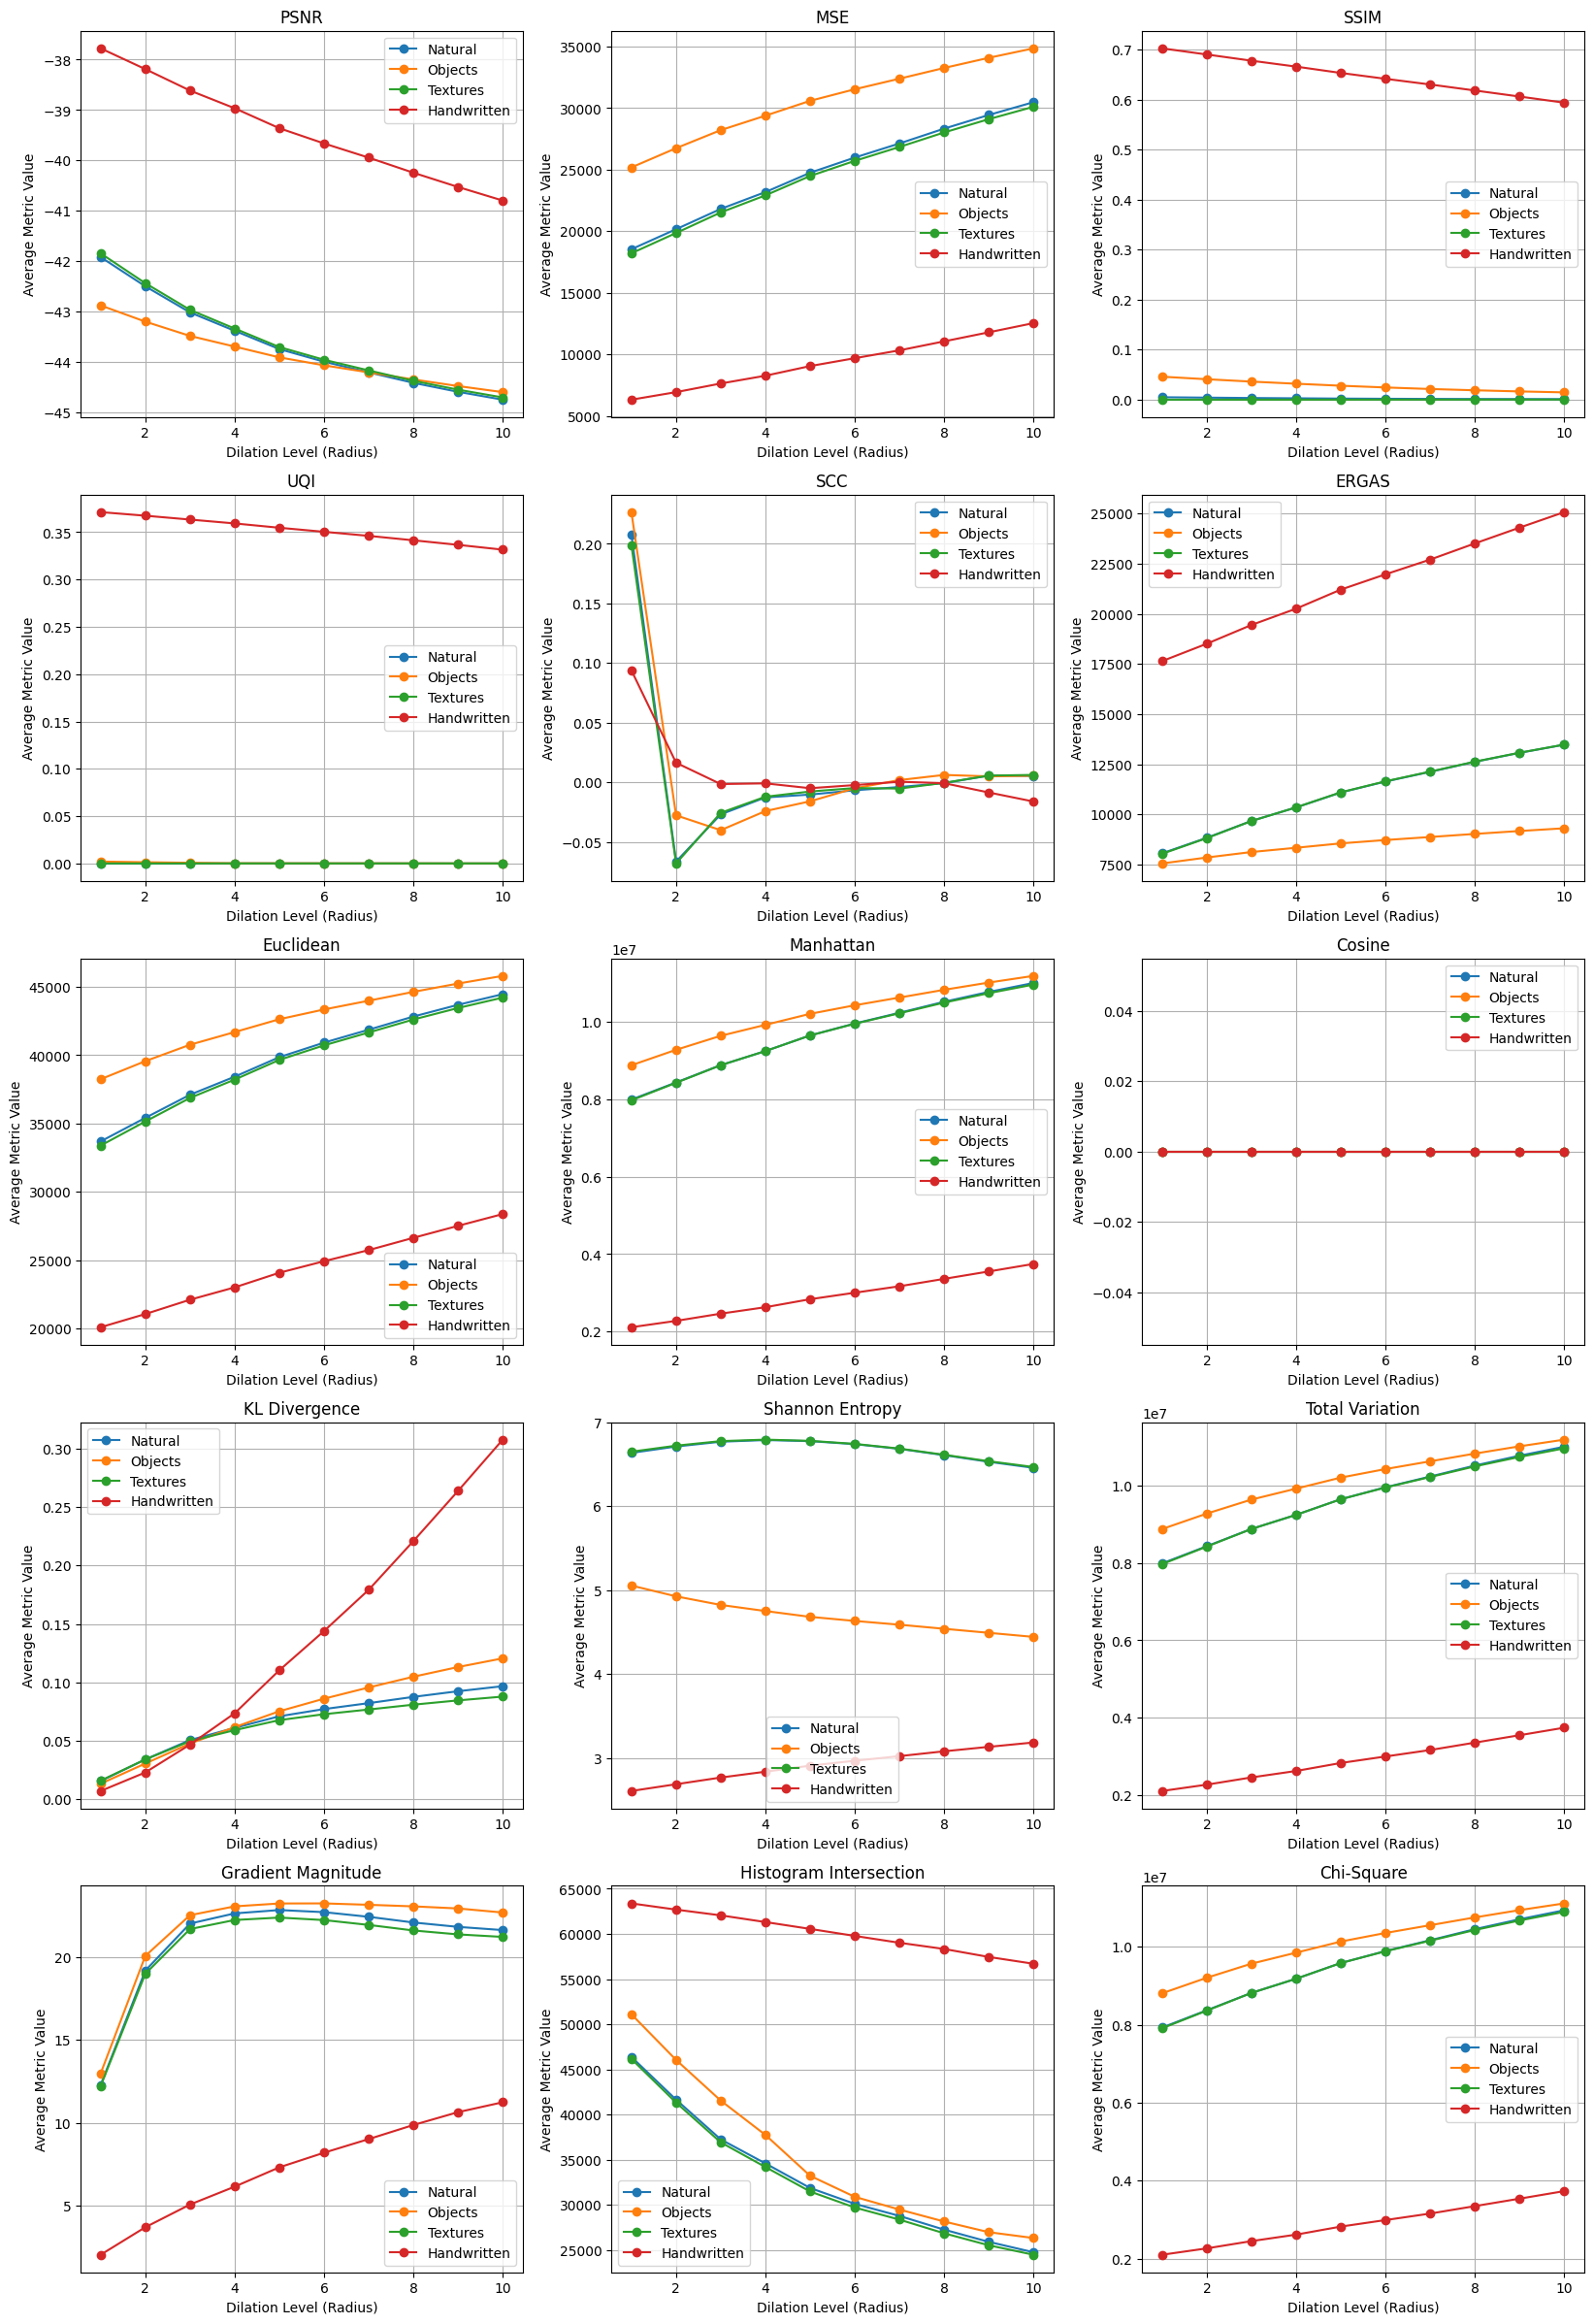

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sewar
from skimage import data, img_as_float
from skimage.morphology import dilation, disk
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from scipy.spatial.distance import euclidean, cityblock, cosine
from scipy.stats import entropy
from skimage.color import rgb2gray, rgba2rgb
from scipy.linalg import norm
from skimage.filters import sobel
from scipy.ndimage import distance_transform_edt
from skimage.transform import resize
from skimage.measure import shannon_entropy
from skimage.util import img_as_ubyte
from tensorflow.keras.datasets import mnist

def preprocess_image(image, size=(256, 256)):
    image = img_as_float(image)
    if image.ndim == 3:
        if image.shape[2] == 4:
            image = rgba2rgb(image)
        image = rgb2gray(image)
    return resize(image, size, anti_aliasing=True)

def apply_dilation(image, radius):
    image = img_as_ubyte(image)
    selem = disk(radius)
    return dilation(image, selem)

def fast_hausdorff(original, modified):
    orig_edges = sobel(original) > 0
    modified_edges = sobel(modified) > 0
    dist_transform = distance_transform_edt(~modified_edges)
    return np.mean(dist_transform[orig_edges])

def compute_metrics(original, modified):
    metrics = {}
    min_side = min(original.shape)
    win_size = min(7, min_side)
    if win_size % 2 == 0:
        win_size -= 1

    metrics['PSNR'] = psnr(original, modified, data_range=1)
    metrics['MSE'] = np.mean((original - modified) ** 2)
    metrics['SSIM'] = ssim(original, modified, data_range=1, win_size=win_size)
    metrics['UQI'] = sewar.uqi(original, modified)
    metrics['SCC'] = sewar.scc(original, modified)
    metrics['ERGAS'] = sewar.ergas(original, modified)
    metrics['Euclidean'] = euclidean(original.ravel(), modified.ravel())
    metrics['Manhattan'] = cityblock(original.ravel(), modified.ravel())
    metrics['Cosine'] = cosine(original.ravel(), modified.ravel())
    metrics['KL Divergence'] = entropy(original.ravel() + 1e-10, modified.ravel() + 1e-10)
    metrics['Shannon Entropy'] = shannon_entropy(modified)
    metrics['Total Variation'] = np.sum(np.abs(original - modified))
    metrics['Gradient Magnitude'] = norm(sobel(original) - sobel(modified))
    metrics['Histogram Intersection'] = np.sum(np.minimum(np.histogram(original, bins=256)[0], np.histogram(modified, bins=256)[0]))
    metrics['Chi-Square'] = np.sum((original.ravel() - modified.ravel())**2 / (original.ravel() + modified.ravel() + 1e-10))
    metrics['Hausdorff Distance'] = fast_hausdorff(original, modified)

    return metrics

stereo_motorcycle = data.stereo_motorcycle()
stereo_motorcycle_left = preprocess_image(stereo_motorcycle[0])

categories = {
    "Natural": [preprocess_image(data.astronaut()), preprocess_image(data.camera()),
                 preprocess_image(data.coffee()), preprocess_image(data.chelsea()),
                 preprocess_image(data.clock()), preprocess_image(data.page()),
                 preprocess_image(data.coins()), preprocess_image(data.brick()),
                 preprocess_image(data.text()), preprocess_image(data.hubble_deep_field())],
    "Objects": [preprocess_image(data.checkerboard()), preprocess_image(data.grass()),
                 preprocess_image(data.moon()), stereo_motorcycle_left,
                 preprocess_image(data.rocket()), preprocess_image(data.horse()),
                 preprocess_image(data.camera()), preprocess_image(data.lily()),
                 preprocess_image(data.cell()), preprocess_image(data.camera())],
    "Textures": [preprocess_image(data.brick()), preprocess_image(data.text()),
                  preprocess_image(data.camera()), preprocess_image(data.page()),
                  preprocess_image(data.coins()), preprocess_image(data.chelsea()),
                  preprocess_image(data.clock()), preprocess_image(data.coffee()),
                  preprocess_image(data.hubble_deep_field()), stereo_motorcycle_left],
    "Handwritten": [preprocess_image(mnist.load_data()[0][0][i] / 255.0) for i in range(10)]
}

dilation_levels = np.arange(1, 11)
metric_names = list(compute_metrics(np.zeros((10, 10)), np.zeros((10, 10))).keys())

results = {category: {key: np.zeros(len(dilation_levels)) for key in metric_names} for category in categories}

for category, images in categories.items():
    for image in images:
        for i, radius in enumerate(dilation_levels):
            dilated_image = apply_dilation(image, radius)
            metrics = compute_metrics(image, dilated_image)
            for key in results[category]:
                results[category][key][i] += metrics[key]

for category in results:
    for key in results[category]:
        results[category][key] /= len(categories[category])

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 30))
axes = axes.ravel()

for i, key in enumerate(results['Natural']):
    for category in results:
        axes[i].plot(dilation_levels, results[category][key], marker='o', label=category)
    axes[i].set_title(key)
    axes[i].set_xlabel("Dilation Level (Radius)")
    axes[i].set_ylabel("Average Metric Value")
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()
